# Project: Investigate a Dataset: *Finding Correlations among Unrelated Variables*

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploring the Data</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## I) Introduction

**Broad question:** How do total forest area and frequency of natural disasters shape a country's obesity rates and murder rates?

> I picked these factors which seem to be unrelated--geography & frequency of natural disasters, to rates of obesity murder, to formulate new interesting questions and uncover unexpected patterns. I also wanted to approach this project through an experimental and free-for-all lens, just to see if I can make any fun or comical conclusions from the giving unrelated datasets. To narrow down my focus, I picked subcategory of [TK] for geography, [TK] for education and [TK] to encompass murder rates. I received all of my data through GapMinder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
# II) Data Wrangling

## A) Gathering Data

#### Natural Disasters
> I took [TK list dataset names here], each depicting the number of deaths of their respective natural disaster. To combine those datasets, I generated a new CSV file named `natural_disaster_deaths.csv`, which depicts the sum of deaths by natural disaster per year for each country.

In [2]:
#Load all DataFrames for natural disasters
filepath_nds = './data/natural_disasters/'

#assign country names as primary indexes
df_drought = pd.read_csv(filepath_nds + 'indicator_drought_killed.csv', index_col = 'Drought killed')
df_earthquake = pd.read_csv(filepath_nds + 'indicator_earthquake_killed.csv', index_col = 'Earthquake killed')
df_epidemic = pd.read_csv(filepath_nds + 'indicator_epidemic_killed.csv', index_col = 'Epidemic killed')
df_flood = pd.read_csv(filepath_nds + 'indicator_flood_killed.csv', index_col = 'Flood killed')
df_storm = pd.read_csv(filepath_nds + 'indicator_storm_killed.csv', index_col = 'Storm killed')
df_tsunami = pd.read_csv(filepath_nds + 'indicator_tsunami_killed.csv', index_col = 'Tsunami killed')

In [3]:
#put all natural disaster DataFrames in a dictionary for iteration
dict_nds = {'drought killed' : df_drought,
            'earthquake killed' : df_earthquake,
            'epidemic killed' : df_epidemic,
            'flood killed' : df_flood,
            'storm killed' : df_storm,
            'tsunami killed' : df_tsunami
            }

#### Total Forest Area
> I am focusing on total natural forest land per country, and so I will exclude factors that indicate if said forest land is reserved for agricultural production.

> From GapMinder, forest area is described as ‘land under natural or planted stands of trees of at least 5 meters in situ, whether productive or not, and excludes tree stands in agricultural production systems (for example, in fruit plantations and agroforestry systems) and trees in urban parks and gardens.' The dataset `forest_area_sq_km.csv` keeps track of the total forest area from 1990 to 2015.

In [4]:
df_forest = pd.read_csv('./data/forest_area_sq_km.csv', index_col='country')
df_forest.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,...,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0
Albania,7890.0,7870.0,7850.0,7830.0,7810.0,7790.0,7770.0,7750.0,7730.0,7710.0,...,7810.0,7800.0,7790.0,7780.0,7760.0,7750.0,7740.0,7730.0,7720.0,7720.0
Algeria,16700.0,16600.0,16500.0,16400.0,16300.0,16200.0,16100.0,16100.0,16000.0,15900.0,...,16100.0,16900.0,17700.0,18400.0,19200.0,19300.0,19300.0,19400.0,19500.0,19600.0
Andorra,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,...,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0
Angola,610000.0,609000.0,607000.0,606000.0,605000.0,604000.0,602000.0,601000.0,600000.0,599000.0,...,590000.0,589000.0,587000.0,586000.0,585000.0,584000.0,582000.0,581000.0,580000.0,579000.0


#### Obesity Rates
> GapMinder provided the age standardized mean for BMI, dividing it into BMI values for men and women. 

Though generally it may seem that a higher BMI indicates a 'healthier' weight for male, [this article](https://signup.weightwatchers.co.uk/util/art/index_art.aspx?art_id=31901&tabnum=1&sc=803&subnav=Science+Library%3A+Health+and+Weight) clarifies that BMI rates above 25 would still indicate ill health: an equal expectation for both men and women.

In [5]:
df_bmi_male = pd.read_csv('./data/bmi_rates/bmi_male.csv', index_col='Country')
df_bmi_female = pd.read_csv('./data/bmi_rates/bmi_female.csv', index_col='Country')

In [6]:
df_bmi_male.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,21.48678,21.46552,21.45145,21.43822,21.42734,21.41222,21.40132,21.37679,21.34018,21.29845,...,20.75469,20.69521,20.62643,20.59848,20.58706,20.57759,20.58084,20.58749,20.60246,20.62058
Albania,25.22533,25.23981,25.25636,25.27176,25.27901,25.28669,25.29451,25.30217,25.30450,25.31944,...,25.46555,25.55835,25.66701,25.77167,25.87274,25.98136,26.08939,26.20867,26.32753,26.44657
Algeria,22.25703,22.34745,22.43647,22.52105,22.60633,22.69501,22.76979,22.84096,22.90644,22.97931,...,23.69486,23.77659,23.86256,23.95294,24.05243,24.15957,24.27001,24.38270,24.48846,24.59620
Andorra,25.66652,25.70868,25.74681,25.78250,25.81874,25.85236,25.89089,25.93414,25.98477,26.04450,...,26.75078,26.83179,26.92373,27.02525,27.12481,27.23107,27.32827,27.43588,27.53363,27.63048
Angola,20.94876,20.94371,20.93754,20.93187,20.93569,20.94857,20.96030,20.98025,21.01375,21.05269,...,21.31954,21.37480,21.43664,21.51765,21.59924,21.69218,21.80564,21.93881,22.08962,22.25083


#### Murder Rates
> Encompasses number of murders per 100,000 people, accounting for all ages.

In [7]:
df_murder = pd.read_csv('./data/homicide_rates.csv', index_col='Murder per 100,000, age adjusted')

In [8]:
df_murder.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005
"Murder per 100,000, age adjusted",,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.650731,NaN,3.837318,3.837318
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.972975,8.115989,6.681117,7.326701
Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.100290,14.410269,9.806334,4.389205
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.767467,NaN,0.726513,0.726513
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,51.057260,NaN,48.206188,48.206188


## B) Data Cleaning

### Natural Disasters
> To account for all natural disasters that occurred in each country, my goal is to generate a new CSV file where each cell contains the sum of all the natural disaster DataFrames.

Let's examine the columns of each natural disaster DataFrame. There are 195 total countries in the world, so I am expecting there to be at most 195 rows.

In [9]:
for key, df in dict_nds.items():
    #display (row, column) per DataFrame
    print(df.index.name, df.shape)

Drought killed (128, 39)
Earthquake killed (97, 39)
Epidemic killed (143, 38)
Flood killed (182, 39)
Storm killed (181, 39)
Tsunami killed (18, 15)


> It can be seen that the DataFrame for tsunamis is the least reported out of all the other natural disasters (accounting for only 18 countries), while the most documented natural disaster is floods, at 181 countries. This adds more ambiguity as to how we should generate our final CSV file accounting for all natural disasters in all countries.

> Now there are two possibilities for approaching this:

Approach 1) The missing countries means that no natural disasters occurred in them, and so it was not necessary to include them in their respective DataFrames.

> Therefore **it is safe to set the values of the missing countries to 0 and generate the final CSV as a sum of all the DataFrames.**

Approach 2) We do not know if any natural disasters occurred in the missing countries.

> Therefore **we should focus only the countries in common who have no missing values.**

I ended up picking **Approach 2** because as can be seen in the above df_drought DataFrame, there are values for 0 in countries and years where no earthquakes happened. The best conclusion I can come for the missing indexed countries is that there has been no data recorded for them, and therefore I cannot assume whether or not earthquakes ever occurred in the missing countries. This logic extends to the rest of the DataFrames for the natural disasters.

### *DROP/REPLACE NULLS*

**Natural Disasters**

In [10]:
#Display number of NaN values in each dataset
for key, df in dict_nds.items():
    #display (row, column) per DataFrame
    print('# NaN in {} : {}'.format(key, df.isna().sum().sum()))

# NaN in drought killed : 0
# NaN in earthquake killed : 0
# NaN in epidemic killed : 0
# NaN in flood killed : 0
# NaN in storm killed : 0
# NaN in tsunami killed : 248


**Only the tsunami dataset has null values.**

In [11]:
#Drop nulls from tsunami dataset
df_tsunami.dropna(inplace=True)

In [12]:
#Confirm changes
df_tsunami.isna().any().any()

False

**But hold up!**
> Before we move on, let's check the first few rows of the tsunami data set:

In [13]:
#Check how many values exist in the tsunami data set
print(df_tsunami.count().sum())

df_tsunami

0


,1979,1980,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
Tsunami killed,,,,,,,,,,,,,,,


The above results show that only the last DataFrame for tsunamis contains null values. 

> The tsunami dataset is completely empty, which means we'll have to discard it. This makes me come to the conclusion that ***every single row in the data set contained a null value, which means that after dropping all the null values, the dataset became completely empty.***

> I know it's painful to have to discard an entire DataFrame, but at least that is better than incorporating largely unreliable data into our final analysis.

Before moving on, let's update our NumPy array to exclude the tsunami dataset.

In [14]:
#Drop tsunami dataset
dict_nds.pop('tsunami killed', None)

#check changes
len(dict_nds)

5

There are only 5 DataFrames in the dictionary instead of 6, so we can move on.

**Total Forest Area**

In [15]:
num_nulls = df_forest.isna().sum().sum()
print('There are {} null values in the forest DataFrame.'.format(num_nulls))

There are 21 null values in the forest DataFrame.


In [16]:
print('There are {} countries recorded in the forest dataset.'.format(df_forest.index.nunique()))

There are 193 countries recorded in the forest dataset.


In [17]:
#check which rows have null values
df_forest[df_forest.isna().any(axis = 1)]

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
South Sudan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,71600.0,71600.0,71600.0,71600.0,71600.0


> Only South Sudan has NaN values, so we can safely remove 1 country for our final Dataset.

In [18]:
#drop South Sudan
df_forest.drop(index = 'South Sudan', inplace = True)

In [19]:
#verify South Sudan no longer exists from forest dataframe
(df_forest.index == 'South Sudan').any(axis = 0)

False

**Obesity Rates** : *Female*

In [20]:
df_bmi_female.isna().sum().sum()

0

***There are 0 NaN values for female obesity rates throughout all years, so we can move on to male obesity rates.***

In [21]:
df_bmi_male.isna().sum().sum()

0

***There are also 0 NaN values for male obesity rates throughout all years, so we can keep these two datasets as they are.***

**Murder Rates**

In [22]:
df_murder.isna().sum().sum()
print('There are {} missing records from our murder rates dataset.'.format(df_murder.isna().sum().sum()))

There are 8521 missing records from our murder rates dataset.


In [23]:
#check for total number of countries
df_murder.index.nunique()

206

In [24]:
#check how many countries
df_murder[df_murder.isna().any(axis = 1)].index.nunique()

198

***Out of 206 countries, 198 have missing records. This means that murder rates are the most unreliable and incomplete variable to examine. We also cannot just drop 198 countries from the entire final dataframe.***

To handle these missing values, I decided I will just **keep the NaN values** and populate our final DataFrame with NaN values for murder rates. 
- When making conclusions based on murder rates, I will focus only on the countries that do not have NaN values for murder rates and the 2nd variable I'm examining.
- It's unreasonable to exclude the majority 198 of countries in my final DataFrame when there are many more variables than murder rates to examine.

### *Dedupe Data*
**Natural Disasters**

In [25]:
#Check for number of duplicate data per row
for key, df in dict_nds.items():
    print(df.duplicated().sum())

101
21
21
30
29


> But wait, we don't want to drop duplicate data just yet. As we know, many of the DataFrames are populated with rows containing only 0's. Before we drop duplicate rows, let's make sure that they are all actually **zeroes** and not just rows populated with the same repeating values.

In [26]:
#Display all duplicated rows in each DataFrame
for key, df in dict_nds.items():
    #return True if the dataset contains a value that's not 0
    print(df[df.duplicated(keep=False)].any().any())
    
    
# print(df[1][df[1].duplicated(keep=False)])

False
True
True
False
True


> Some of the DataFrames have values that are greater than 0. But I've come to realize I don't necessarily care about the duplicate values themselves. The real question is: **are they repeating countries?** 


In [27]:
#Check if any of the DataFrames have duplicate index 'country'
for key, df in dict_nds.items():
    #return True if the dataset contains a repeating country
    print(df.index.duplicated().sum().any())

False
False
False
False
False


> None of the DataFrames have repeating countries for indexes. This is good news! Our data has turned out to be much more reliable than expected.

Now we can decide to drop the duplicated rows or not, but I have **ultimately decided not to.** This is an exceptional case. Dropping the rows could harm our data reliability in the end, because dropping duplicates means we would be getting rid of natural disaster scores for entire countries in the long run.

### Because we established that duplicate countries indicates *real* duplicate data instead of duplcate countries, I'll only be examining the country indices from now on.

**Total Forest Area**

In [28]:
#check for repeating countries: return False if none
df_forest.index.duplicated().any()

False

**Obesity Rates**

In [29]:
#check for repeating countries: return False if none
print(df_bmi_female.index.duplicated().any())
print(df_bmi_male.index.duplicated().any())

False
False


**Murder Rates**

In [30]:
#check for repeating countries: return False if none
print(df_murder.index.duplicated().any())

False


### There are absolutely no duplicate records in any of our DataFrames. This is good news! 

### *FIX DATA TYPES*

**Natural Disasters**

Counting the number of natural disaster occurrences means handling **discrete variables**, so it would make the most sense to convert all of the values in every DataFrame to integers.

In [31]:
#Display data types of each DataFrame, besides 'country'
for key, df in dict_nds.items():
    print(np.unique(df.dtypes))

[dtype('int64')]
[dtype('int64')]
[dtype('int64')]
[dtype('int64')]
[dtype('int64')]


All of the columns contain only integer values, so we do not have to perform any data type conversion or extraction.

In [32]:
from functools import reduce

column_names = []
for key, df in dict_nds.items():
    column_names.append(df.columns.values)

#find years in common
reduce(np.intersect1d, column_names)

array(['1970', '1971', '1972', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008'], dtype=object)

The year 1973 is missing from one or more of the DataFrames. After manually scrolling through the previous years, we can see that `df_epidemic` is the one with the missing year.

In [33]:
#verify 1973 does not exist
df_epidemic.columns[1:5]

Index(['1971', '1972', '1974', '1975'], dtype='object')

**Total Forest Area**

Forest area, BMI ratings, and murder rates are all ***continuous variables***, so it's best to keep them as ***floats.***

In [34]:
#check unique types
df_forest.dtypes.unique()

array([dtype('float64')], dtype=object)

**Obesity Rates**

In [35]:
#male obesity rates
df_bmi_male.dtypes.unique()

array([dtype('float64')], dtype=object)

In [36]:
#female obesity rates
df_bmi_female.dtypes.unique()

array([dtype('float64')], dtype=object)

**Murder Rates**

In [37]:
df_murder.dtypes.unique()

array([dtype('float64')], dtype=object)

### For natural disasters, all column types have been converted to integer type due to their values being discrete in nature. For all other datasets, however, all continuous types have been preserved as floats.

### ALL: *Convert index to a column named 'country'*

In [38]:
#create dictionary with all datasets
dict_non_nds = {'total forest area' : df_forest,
               'male bmi' : df_bmi_male,
               'female bmi' : df_bmi_female,
               'murder rate' : df_murder
}

dict_all = {**dict_nds, **dict_non_nds}

#verify datasets have been added
dict_all.keys()

dict_keys(['drought killed', 'earthquake killed', 'epidemic killed', 'flood killed', 'storm killed', 'total forest area', 'male bmi', 'female bmi', 'murder rate'])

In [39]:
#move index of countries to its own column

for key, df in dict_all.items():
    #rename moved column name to 'country'
    new_columns = np.insert(df.columns.values, 0, 'country', axis = 0)
    df.reset_index(inplace = True)
    df.columns = new_columns
    
    #verify that all dfs have column named 'country'
    print(np.any(df.columns.values == 'country'))

True
True
True
True
True
True
True
True
True


### ALL: *MELT DATA*

***Melt all year columns under a single column named 'year'***

In [40]:
#assign new column names as the current dictionary key's pythonic snake case
for key, df in dict_all.items():
    dict_all[key] = pd.melt(df, id_vars = 'country', var_name = 'year', value_name = key.replace(' ', '_'))
    
    #verify that all dfs have a column named 'year'
    print(np.any(dict_all[key].columns.values == 'year'))

True
True
True
True
True
True
True
True
True


### ALL: *OUTER MERGE DATASETS*
> **Main idea:** We are using an ***outer merge*** because our data implies that each country in each DataFrame satisfies the following conditions:

1) contains reliable non-null data

2) represents the true number of its respective natural disaster per year

> Consider that we are merging df1 and df2.

If df1 contains countries that df2 does not AND df2 contains countries that df1 does not, we want all of those countries to show up in the final result.

If df2 contains years that df2 does not AND df2 contains years that df1 does not, we want all of those years to show up in the final result anyway.

**Natural Disasters**

In [74]:
#drop indices from all datasets to consistent merging
for key, df in dict_all.items():
    dict_all[key].reset_index(drop = True, inplace = True)

In [75]:
#merge all natural disaster datasets
df_all = pd.concat(list(dict_all.values()), sort = True, join = 'outer')

### There is an abundance of NaN values in our clean DataFrame, but I decided to ultimately keep them. This is because:

1. dropping all rows with NaN values would ultimately render an empty DataFrame,
2. replacing all NaN values with 0s would heavily impact the skews, calculations, and analysis of our data.

### Check that our clean data is consistent with the original data

> non-updated DataFrames in `dict_all` vs. clean DataFrames in `df_all`

In [85]:
#isolate old and new value counts
for key, df in dict_all.items():
    column = key.replace(' ', '_')
    old_counts = df[column].value_counts().sort_index(ascending = True).values
    new_counts = df_all[column].value_counts().sort_index(ascending = True).values
    
    #return True if all old and new counts are consistent
    print(~(np.any((old_counts == new_counts) == False)))

True
True
True
True
True
True
True
True
True


### All of our pre- and post- value counts are consistent, so we know our data wasn't lost/altered in any way.

## Reorder columns
> Reorder the columns as so: *country, year, natural disasters, forest area, BMI ratings, murder rates*



In [52]:
df_all.head(1)

,country,drought_killed,earthquake_killed,epidemic_killed,female_bmi,flood_killed,male_bmi,murder_rate,storm_killed,total_forest_area,year
0,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1970


In [76]:
#declare column order

cols_order = ['country', 'year',
              'drought_killed', 'earthquake_killed', 'epidemic_killed', 'flood_killed', 'storm_killed',
              'total_forest_area',
              'female_bmi', 'male_bmi',
              'murder_rate'
             ]

In [77]:
#reassign column order
df_all = df_all[cols_order]

In [78]:
#verify change
df_all.head(1)

,country,year,drought_killed,earthquake_killed,epidemic_killed,flood_killed,storm_killed,total_forest_area,female_bmi,male_bmi,murder_rate
0,Afghanistan,1970,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Store clean dataframe

In [80]:
df_all.to_csv('./data/mindgap_all.csv', encoding = 'utf-8', index = False)

<a id='eda'></a>
# III) Exploring the Data

## Load Data

In [81]:
df_mg = pd.read_csv('./data/mindgap_all.csv')

## Explore

In [82]:
df_mg.describe()

,year,drought_killed,earthquake_killed,epidemic_killed,flood_killed,storm_killed,total_forest_area,female_bmi,male_bmi,murder_rate
count,56436.000000,4992.000000,3783.000000,5434.000000,7098.000000,7059.000000,4.992000e+03,5771.000000,5771.000000,3015.000000
mean,1988.906549,135.740585,218.106265,35.921973,35.082840,111.081598,2.104528e+05,24.674888,24.007244,6.646096
std,13.575431,5157.834533,4654.818243,292.167925,527.328405,4286.325785,7.865677e+05,2.622642,2.311251,10.445316
min,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,18.471660,19.013940,0.000000
25%,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.340000e+03,22.696370,21.871030,1.099403
50%,1990.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.480000e+04,25.000960,24.415860,2.285359
75%,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.102500e+05,26.276810,25.687395,7.731115
max,2015.000000,300000.000000,242000.000000,9726.000000,30005.000000,300317.000000,8.150000e+06,35.022940,33.896340,130.982300


**Observation 1:** Of all the natural disasters, ***earthquakes killed more people on average for all years at 218 people.*** On the contrary, ***floods killed the least amount of people, at 35 people on average.***

**Observation 2:** For all countries and years, ***around 7 people are killed per 100,000 people***. This is a very low count, but then we see that ***at maximum, 131 people are killed per 100,000***. This raises the question: would this country/year be an outlier?

**Observation 3:** For all 25th, 50th, and 75th percentiles, ***no natural disaster occurred.*** This implies that natural disasters *rarely ever happen, or are poorly recorded.*

**Observation 4:** Of all the natural disasters, droughts have the highest standard deviation at 5158 people. This means that ***droughts have the highest variability in mortality counts compared to all other natural disasters.*** This may be reflective of the fact that *droughts affect certain areas of the world more than areas, especially countries with high amounts of dry land.* 

**Observation 5:** The average total forest area for any given country/year pair is ***18,615 square kilometers.*** This really is not much land, compared to the most heavily forested record at ***815,000 square kilometers.*** So far, none of the country/year pairs listed has a forest area coverage in the millions.

**Observation 6:** There is higher variability in female BMI vs. male BMI rates. Additionally, both the mean and maximum female BMI rates are ***greater*** than the male BMI scores, respectively. However, the minimum female BMI rate is ***lesser*** than the minimum male BMI. The counts in male and female BMI scores are the same at 5771, which means that ***gender is evenly split, and thus we can draw confident conclusions from gender comparison.***

**Observation 7:** Of all the natural disasters, ***floods are the most frequently recorded, 7098 times. Yet floods kill the least amount of people. On the contrary, earthquakes are the least frequently recorded, 3783 times. Yet earthquakes kill the most amount of people.**

**Observation 8:** The stark disparity in the previous observation is an interesting relationship to observe. This implies that *the natural disasters which occur the least frequently are the most deadly, while the ones that occur the most frequently are the least deadly.* Sounds like a fair trade off to me.

----------------------------

**Question 1:** Which country has the highest homicide rate? What about just country? Or year? Is this an outlier?

**Question 2:** Do countries with less forest area tend to have higher rates of death by drought?

### Visualize

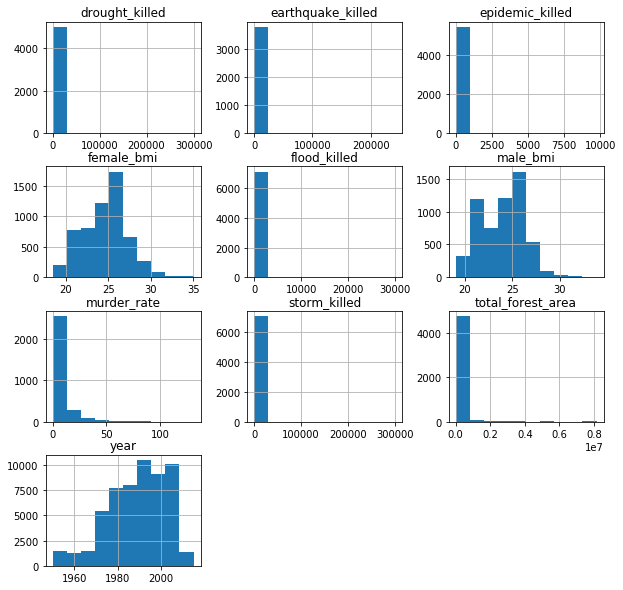

In [97]:
df_mg.hist(figsize = [10, 10]);
plt.savefig('./visuals/hist-all.png')

**Observation 1:** The highest amount of records for years are between 1990 and 2000, while the 1960s-70s have the least amount of data. However, there is a sharp, steep trough in counts just after 2000. This means that ***the more recent the year is before 2000, the more reliable and representative the data.***

**Observation 2:** Female BMI scores appear normally distributed while male BMI scores appear bimodal. However, ***BMI scores for both genders have peaks at around a score of 25***, which implies that the average human teeters between normal (healthy weight) and overweight.

**Observation 3:** Murder rates are severely right-skewed, which further supports my hypothesis that ***the country with the max amount of homicide counts per 100,000 is an outlier.*** That outlier is so significant that it affects the entire distribution for murder rates.

**Observation 4:** The peak count of murder rates is at over 2,000 for rates between 0 and approximately 25.

**Observation 5:** There is a continuous trend of ***severe right-skewness for all distributions aside from year and BMI scores.*** This is both good and bad news.
- The good news: there are significantly lesser counts for natural disaster mortality counts.
- The bad news: the average country has much virtually minimal total forest area.

---


### Question 1: Which country has the highest homicide rate? Which year? Do either of these variables act as outliers?

In [114]:
#isolate max homicide rate
df_mg[df_mg.murder_rate == df_mg.murder_rate.max()]

,country,year,drought_killed,earthquake_killed,epidemic_killed,flood_killed,storm_killed,total_forest_area,female_bmi,male_bmi,murder_rate
51358,Guatemala,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.9823


**Observation 1:** Guatemala has the highest murder rate at 131 people per 100,000.

**Observation 2:** There are no other records for Guatemala, so it will be impossible to draw a relationship between these variables for the year 1981.

---
### Question 1a: How do murder rates for Guatemala vary by year? Are there records for the other features for those years?


In [116]:
#isolate all records for Guatemala
df_guatemala = df_mg[df_mg.country == 'Guatemala']

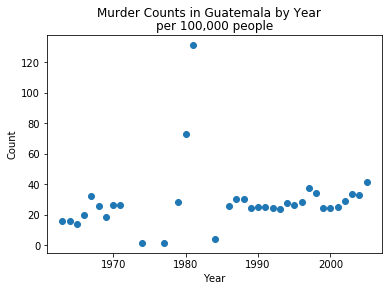

In [129]:
#show trend
plt.scatter(data = df_guatemala, x = 'year', y = 'murder_rate')
plt.ylabel('Count')
plt.xlabel('Year')
plt.suptitle('Murder Counts in Guatemala by Year')
plt.title('per 100,000 people')

plt.savefig('./visuals/guatemala-murder-rate.png')

**Observation 1:** My prediction was correct: ***the record with the highest global murder rate is, in fact, an outlier.*** A severe one at that, too. 

**Observation 2:** The trend in murder rates by year for Guatemela appears to be normal, but then ***largely unpredictable and varied between the mid 1970s to late 1980s.*** The mid 1970s found a sharp decrease in murder rates even compared to previous trends. However, murder rates *skyrocketed* in such a short amount of time, reaching the max at around 1980 and they *sharply decreased* in just about the same amount of time. After the mid-1980s, murder rates started to normalize just like the trends before the mid 1970s.

**Observation 3:** The mid-1970s to late 1980s depict ***both the record highest and record lowest murder rates***, hence these years' large unpredictability. This is a key insight because the [Guatemalan Civil War](https://www.pri.org/stories/2016-12-29/why-you-need-know-about-guatemalas-civil-war) is the major event that took place during these years.

**Observation 4:** Murder rates have been linearly increasing from the early 2000s onward. In a cruel twist of irony, safety in Guatemala is decreasing but at least this murder trend is predictable unlike the 1970s. 

**Observation 5:** Without the outliers from the years of the Guatemalan Civil War, the overall trend appears more or less ***positively linear but weak.*** With the outliers, however, the trend appears to be ***normally distributed.***

### Question 2: Do countries with less forest area tend to have higher rates of death by drought?

In [135]:
#verify there are records with BOTH drought and forest area fields are not null
df_mg.loc[~(df_mg.drought_killed.isna()) & ~(df_mg.total_forest_area.isna())]

,country,year,drought_killed,earthquake_killed,epidemic_killed,flood_killed,storm_killed,total_forest_area,female_bmi,male_bmi,murder_rate


> There are no records where both `total_forest_area` and `drought_killed` fields are not null. So ***Question 2 leads to a dead end.***

### Question 3: How much have global obesity rates changed in countries with high forest area vs. countries with low forest area?

In [138]:
#verify there are records with BOTH forest area and male bmi rates are not null
df_mg.loc[~(df_mg.total_forest_area.isna()) & ~(df_mg.male_bmi.isna())]

,country,year,drought_killed,earthquake_killed,epidemic_killed,flood_killed,storm_killed,total_forest_area,female_bmi,male_bmi,murder_rate


In [139]:
df_mg.loc[~(df_mg.total_forest_area.isna()) & ~(df_mg.female_bmi.isna())]

,country,year,drought_killed,earthquake_killed,epidemic_killed,flood_killed,storm_killed,total_forest_area,female_bmi,male_bmi,murder_rate


> There are no records where `total_forest_area`, `bmi_male`, and `bmi_female` fields are not null. ***There is a recurring theme where the low count of forest area is a hard variable to do anything with.***

**To combat this problem, let's isolate the rows where `total_forest_area` is *not* null.**

In [148]:
#isolate
df_forest_nna = df_mg.loc[~(df_mg.total_forest_area.isna())]

#look for counts of non-null values in other rows
df_forest_nna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4992 entries, 28366 to 33357
Data columns (total 11 columns):
country              4992 non-null object
year                 4992 non-null int64
drought_killed       0 non-null float64
earthquake_killed    0 non-null float64
epidemic_killed      0 non-null float64
flood_killed         0 non-null float64
storm_killed         0 non-null float64
total_forest_area    4992 non-null float64
female_bmi           0 non-null float64
male_bmi             0 non-null float64
murder_rate          0 non-null float64
dtypes: float64(9), int64(1), object(1)
memory usage: 468.0+ KB


> Of all the fields where `total_forest_area` is not null, ***all other fields besides country and year have no data.*** Therefore, total forest area is a useless variable to make comparisons to natural disaster, BMI, and murder rate fields.

**Question 3a:** How does global total forest area trend with year?

**Question 3b:** Which countries have the highest amount of total forest area?


### [TK] create visual correlating year with country Question 3a: How do global total forest areas trend with year?

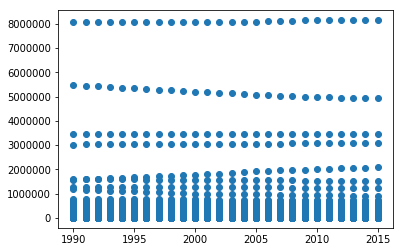

In [149]:
#create visual
plt.scatter(data = df_mg, x = 'year', y = 'total_forest_area')

### Question 3b: Which countries have the highest amount of mean total forest area?

In [157]:
#isolate total forest area by country, in descending order
forest_order = df_mg.groupby('country').mean().total_forest_area.sort_values(ascending = False)

In [173]:
#top 10 countries, descending order
forest_order.index[:10]

Index(['Russia', 'Brazil', 'Canada', 'United States', 'China',
       'Congo, Dem. Rep.', 'Australia', 'Indonesia', 'Peru', 'Mexico'],
      dtype='object', name='country')

In [174]:
#bottom 10 countries, descending order
forest_order.index[-10:]

Index(['USSR', 'Virgin Islands (U.S.)', 'Wallis ', 'Wallis et Futuna',
       'West Bank and Gaza', 'West Germany', 'Yemen Arab Republic (Former)',
       'Yemen Democratic (Former)', 'Yemen, Rep.', 'Yugoslavia'],
      dtype='object', name='country')

**Observation 1:** The top 10 countries with the most forest area comprise of countries that are at least 1 of the following characteristics: is a world superpower, contains a rainforest climate.

**Observation 2:** The bottom 10 countries with the least amount of forest area contain at least 1 of the following characteristics: ***is majority desert/arid climate, is a heavily industrialized country, is currently experiencing warfare and crisis.*** 

All of these characteristics intuitively make sense; the less warfare and industrialization, and the more access there is to natural resources, the more a country is likely to have a wider span of total forest area.

### Does a country’s likelihood of experiencing a natural disaster affect the homicidal tendencies of its citizens?

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
# IV) Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])